In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy
import seaborn as sns
from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [2]:
# load light curve segments
with open('{}/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5"
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 20 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [3]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [4]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [5]:
with open('{}/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [6]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_222comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_1s = pickle.load(f)

# find clusters for the data
GMmodel_1s_labels = GMmodel_1s.predict(shape_moments)

In [7]:
# calculate mahalanobis distances between components
# GM_comp_mahal_distances_1s = component_mahalanobis_distances(GMmodel_1s)

# with open("GM_comp_mahal_distances_1s.pkl", 'wb') as f:
#     pickle.dump(GM_comp_mahal_distances_1s, f)

with open('GM_comp_mahal_distances_1s.pkl', 'rb') as f:
    GM_comp_mahal_distances_1s = pickle.load(f)

In [8]:
def merge_gaussian_component_labels(distance_matrix, observation_labels, sigma_threshold):
    """
        if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, relabel the data within
    those components as belonging to a new, single cluster
    
    input:
        distance_matrix - square matrix containing distances between Gaussian component means, output of component_mahalanobis_distances function
        observation_labels - list of data labels corresponding to the Gaussian components
        sigma_threshold - threshold for the merger of Gaussian components. If distances between two component means are less then the threshold,
        (both when calculating from A to B and from B to A), the components will be treated as one cluster.
                            
    output
        new_observation_labels - modified observation_labels, where a new index was created for merged components, and both component indices were
        replaced with that new index
    

    uses the graph solution from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
    """
    # find pairs of components whose means are separated by mahalanobis distance smaller than the threshold (both ways)
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    new_observation_labels = observation_labels
    # merge components
    for n_connection, connection in enumerate(connected_components(G)):
        node_indices=np.array([int(node) for node in connection])
#         new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
#                                           n_connection+np.unique(observation_labels).shape[0], new_observation_labels)
        new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
                                          node_indices[0], new_observation_labels)
        
    return new_observation_labels


In [ ]:
# [3.3383838383838382, (0.813872309508673, 0.8540909090909081, ('gini', 5))]
results = []


data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.34)
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"


# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

np.random.seed(seed=11)
for test_iter in range(10):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    criterion = 'gini',
                                    n_estimators=1000,
                                    max_depth=5, 
                                    min_samples_split=2,
                                    min_samples_leaf = 1,
                                    n_jobs=35
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

In [ ]:
# with open("test_results_gini_depth5_mahal3-34_1000rng_mu_withshuffling.pkl", 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
results

In [ ]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

In [ ]:
np.argmin(np.absolute(np.array([x for x,y in results])-np.mean([x for x,y in results])))

In [ ]:
np.argmax(np.array([x for x,y in results]))

In [ ]:
plt.hist(np.array([x for x,y in results]))
# plt.show()

In [ ]:
np.random.seed(seed=11)

RF_clf = RandomForestClassifier(random_state=0,
                                class_weight="balanced",
                                criterion = 'gini',
                                n_estimators=1000,
                                max_depth=5, 
                                min_samples_split=2,
                                min_samples_leaf = 1,
                                n_jobs=35
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

In [ ]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.15, 3.15)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
# plt.savefig('figures_paper/classification_matrix.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [6]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        if ob == "10258-01-10-00":
            segment_class.append("mu")
        else:
            segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")



ids_ar = np.array(segment_class)

phi_stats = np.take(desc_stats, np.where(ids_ar == "phi")[0], axis=0)
chi_stats = np.take(desc_stats, np.where(ids_ar == "chi")[0], axis=0)
gamma_stats = np.take(desc_stats, np.where(ids_ar == "gamma")[0], axis=0)

phi_stats[:,:2] /=1000
chi_stats[:,:2] /=1000
gamma_stats[:,:2] /=1000

In [ ]:
# axes = axes.flatten()
plt.rcParams['figure.figsize'] = (3.15, 6.97)#6.97)
plt.rcParams.update({'font.size': 6})

fig, axes = plt.subplots(nrows=4, ncols=1)

for plot_ind in range(4):
#     light_c = selected_lcs[plot_ind]
    stat_df = pd.DataFrame([phi_stats[:,plot_ind],chi_stats[:,plot_ind],gamma_stats[:,plot_ind]], index = [r"$\{}$".format(x) for x in ["phi", "chi", "gamma"]]).T #r"$\{}$"[r"$\{}$".format(x) for x in ["phi", "chi", "gamma"]]
    stat_df.boxplot(whis=[5,95], sym="", ax=axes[plot_ind], grid=False)
#     axes[plot_ind].tick_params(axis="x", which="major", length=0, width=1, labelsize=0, direction="in")
    axes[plot_ind].tick_params(axis="y", which="major", length=2, width=1, labelsize=6, direction="in")
    if plot_ind != 3:
        axes[plot_ind].set_xticks([])
        axes[plot_ind].set_xticklabels([])
    else:
#         axes[plot_ind].tick_params(axis="x", which="major", length=2, width=1, labelsize=6, direction="in")
        axes[plot_ind].tick_params(axis="x", which="major", length=0, width=1, labelsize=8, direction="in")
        
    axes[plot_ind].set_ylabel(["mean (kcts/s)", "standard deviation (kcts/s)", "skewness", "kurtosis"][plot_ind])
plt.subplots_adjust(hspace=0.01)
plt.subplots_adjust(wspace=0.00)
# axes.reshape((2,2))
# plt.savefig('figures_paper/boxplot.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

# axes[1] = stat_df.boxplot(whis=[1,99], sym="")#plt.gca()
plt.show()

In [7]:
phi_sifos = np.take(shape_moments, np.where(ids_ar == "phi")[0], axis=0)
chi_sifos = np.take(shape_moments, np.where(ids_ar == "chi")[0], axis=0)
gamma_sifos = np.take(shape_moments, np.where(ids_ar == "gamma")[0], axis=0)
rho_sifos = np.take(shape_moments, np.where(ids_ar == "rho")[0], axis=0)
# trans_shape_pcgr = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,:20],chi_sifos[:,:20], gamma_sifos[:,:20], rho_sifos[:,:20])))
trans_shape_pcg = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,:20],chi_sifos[:,:20], gamma_sifos[:,:20])))

In [8]:
break_1 = len(phi_sifos)
break_2 = break_1+len(chi_sifos)
break_3 = break_2+len(gamma_sifos)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


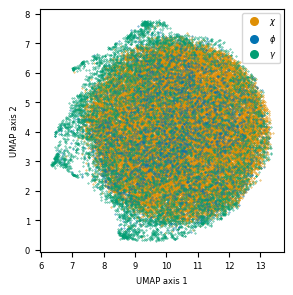

In [18]:
plt.rcParams['figure.figsize'] = (3.15, 3.15)#6.97)
plt.rcParams.update({'font.size': 6})

fig, axes = plt.subplots(nrows=1, ncols=1)

# plt.scatter(trans_shape_pcgr.embedding_[break_3:, 0], trans_shape_pcgr.embedding_[break_3:, 1],s=0.1,zorder=1, label=r"$\rho$",
#             color=sns.color_palette("colorblind", n_colors=5)[4])
plt.scatter(trans_shape_pcg.embedding_[break_1:break_2, 0], trans_shape_pcg.embedding_[break_1:break_2, 1],s=0.1,zorder=1, label=r"$\chi$",
            color=sns.color_palette("colorblind", n_colors=5)[1])
plt.scatter(trans_shape_pcg.embedding_[:break_1, 0], trans_shape_pcg.embedding_[:break_1, 1],s=0.1,zorder=1, label=r"$\phi$",
            color=sns.color_palette("colorblind", n_colors=5)[0])
plt.scatter(trans_shape_pcg.embedding_[break_2:break_3, 0], trans_shape_pcg.embedding_[break_2:break_3, 1],s=0.1,zorder=1, label=r"$\gamma$",
            color=sns.color_palette("colorblind", n_colors=5)[2])
lgnd = plt.legend(fontsize=6)

# axes.text(0.05,0.99,"a", ha='right', va='top', transform=axes.transAxes, size=10)


#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
# lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

plt.savefig('figures_paper/UMAP_SFoS_norho.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)
# plt.title('Embedding of the training set by UMAP', fontsize=24);
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (3.15, 3.15)#6.97)
plt.rcParams.update({'font.size': 6})

fig, axes = plt.subplots(nrows=1, ncols=1)

plt.scatter(trans_shape_pcgr.embedding_[break_3:, 0], trans_shape_pcgr.embedding_[break_3:, 1],s=0.1,zorder=1, label=r"$\rho$",
            color=sns.color_palette("colorblind", n_colors=5)[4])
plt.scatter(trans_shape_pcgr.embedding_[break_1:break_2, 0], trans_shape_pcgr.embedding_[break_1:break_2, 1],s=0.1,zorder=1, label=r"$\chi$",
            color=sns.color_palette("colorblind", n_colors=5)[1])
plt.scatter(trans_shape_pcgr.embedding_[:break_1, 0], trans_shape_pcgr.embedding_[:break_1, 1],s=0.1,zorder=1, label=r"$\phi$",
            color=sns.color_palette("colorblind", n_colors=5)[0])
plt.scatter(trans_shape_pcgr.embedding_[break_2:break_3, 0], trans_shape_pcgr.embedding_[break_2:break_3, 1],s=0.1,zorder=1, label=r"$\gamma$",
            color=sns.color_palette("colorblind", n_colors=5)[2])
lgnd = plt.legend(fontsize=6)

# axes.text(0.05,0.99,"a", ha='right', va='top', transform=axes.transAxes, size=10)


#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

plt.savefig('figures_paper/UMAP_SFoS.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)
# plt.title('Embedding of the training set by UMAP', fontsize=24);
plt.show()

In [13]:
# trans_intensity_pcgr = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,20:],chi_sifos[:,20:], gamma_sifos[:,20:], rho_sifos[:,20:])))
trans_intensity_pcg = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,20:],chi_sifos[:,20:], gamma_sifos[:,20:])))


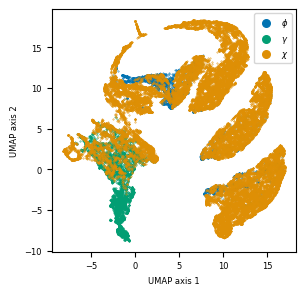

In [21]:
plt.rcParams['figure.figsize'] = (3.15, 3.15)#6.97)
plt.rcParams.update({'font.size': 6})

# plt.scatter(trans_intensity_pcgr.embedding_[break_3:, 0], trans_intensity_pcgr.embedding_[break_3:, 1],s=0.1,zorder=1,
#             label=r"$\rho$", color=sns.color_palette("colorblind", n_colors=5)[4])

plt.scatter(trans_intensity_pcg.embedding_[break_1:break_2, 0], trans_intensity_pcg.embedding_[break_1:break_2, 1],s=0.1,zorder=1,
            label=r"$\chi$", color=sns.color_palette("colorblind", n_colors=5)[1])

plt.scatter(trans_intensity_pcg.embedding_[:break_1, 0], trans_intensity_pcg.embedding_[:break_1, 1],s=0.1,zorder=1,
            label=r"$\phi$", color=sns.color_palette("colorblind", n_colors=5)[0])
plt.scatter(trans_intensity_pcg.embedding_[break_2:break_3, 0], trans_intensity_pcg.embedding_[break_2:break_3, 1],s=0.1,zorder=1,
            label=r"$\gamma$", color=sns.color_palette("colorblind", n_colors=5)[2])



lgnd = plt.legend(fontsize=6)

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
# lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

# plt.savefig('figures_paper/UMAP_IFoS_norho.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (3.15, 3.15)#6.97)
plt.rcParams.update({'font.size': 6})

plt.scatter(trans_intensity_pcgr.embedding_[break_3:, 0], trans_intensity_pcgr.embedding_[break_3:, 1],s=0.1,zorder=1,
            label=r"$\rho$", color=sns.color_palette("colorblind", n_colors=5)[4])
plt.scatter(trans_intensity_pcgr.embedding_[break_1:break_2, 0], trans_intensity_pcgr.embedding_[break_1:break_2, 1],s=0.1,zorder=1,
            label=r"$\chi$", color=sns.color_palette("colorblind", n_colors=5)[1])
plt.scatter(trans_intensity_pcgr.embedding_[:break_1, 0], trans_intensity_pcgr.embedding_[:break_1, 1],s=0.1,zorder=1,
            label=r"$\phi$", color=sns.color_palette("colorblind", n_colors=5)[0])
plt.scatter(trans_intensity_pcgr.embedding_[break_2:break_3, 0], trans_intensity_pcgr.embedding_[break_2:break_3, 1],s=0.1,zorder=1,
            label=r"$\gamma$", color=sns.color_palette("colorblind", n_colors=5)[2])
lgnd = plt.legend(fontsize=6)

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

plt.savefig('figures_paper/UMAP_IFoS.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [15]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        if ob == "10258-01-10-00":
            segment_class.append("mu")
        else:
            segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [22]:
new_classification = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 0)

Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

comparison_matrix = np.zeros((len(np.unique(new_classification)), len(Belloni_classes)), dtype=int)

comparison_matrix_df = pd.DataFrame(comparison_matrix, columns=Belloni_classes, index=np.unique(new_classification))

for n_Bc, Belloni_class in enumerate(Belloni_classes):
    Belloni_class_indices = np.where(np.array(segment_class) == Belloni_class)[0]
    count_clusters_for_class = np.unique(np.take(new_classification, Belloni_class_indices), return_counts=True)
    for cluster_ind, cluster in enumerate(count_clusters_for_class[0]):
        comparison_matrix_df[Belloni_class][cluster] = count_clusters_for_class[1][cluster_ind]

In [23]:
class_normalized_comparison_matrix_df=(comparison_matrix_df-comparison_matrix_df.min())/(comparison_matrix_df.max()-comparison_matrix_df.min())
known_comparison_matrix_df = comparison_matrix_df.drop(columns=['Unknown']).T
component_normalized_comparison_matrix_df = (known_comparison_matrix_df-known_comparison_matrix_df.min())/(known_comparison_matrix_df.max()-known_comparison_matrix_df.min())

In [24]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
def seriation(Z,N,cur_index):
    '''
    https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
    https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
#     seriated_dist = np.zeros((N,N))
#     a,b = np.triu_indices(N,k=1)
#     seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
#     seriated_dist[b,a] = seriated_dist[a,b]
    
    return res_order

In [25]:
no_components = len(cluster_centroids)
GM_comp_euclid_distances = np.zeros((no_components,no_components))
for comp1_ind, comp1 in enumerate(cluster_centroids):
    for comp2_ind, comp2 in enumerate(cluster_centroids):
        GM_comp_euclid_distances[comp1_ind, comp2_ind] = distance.euclidean(comp1, comp2)
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

NameError: name 'cluster_centroids' is not defined

In [ ]:
new_cluster_order  = compute_serial_matrix(GM_comp_euclid_distances,method="single") 
new_cluster_order= np.take(class_normalized_comparison_matrix_df.T.columns.values, new_cluster_order)

In [ ]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True)[new_cluster_order], xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(AutoMinorLocator())

classes_names = class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True).index.values
ax.set_yticklabels([r"$\{}$".format(c) for c in classes_names])


plt.xlabel("Cluster index")
plt.ylabel("Classification")

# plt.savefig('figures_paper/class_heatmap_222.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [111]:
with open('{}/1776_light_curves_1s_bin_errorfix.pkl'.format(data_dir), 'rb') as f:
    lcs = pickle.load(f)
with open('{}/1776_light_curves_1s_bin_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    ids = pickle.load(f)
    
    
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state


        

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

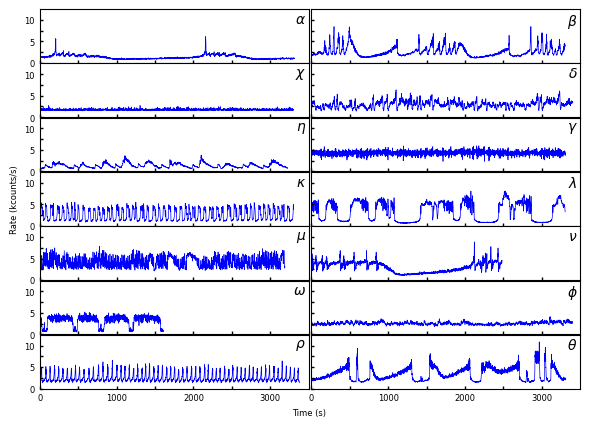

In [119]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker

pylab.rcParams['figure.figsize'] = (6.97, 6.97*(21.0/29.7) ) # A4 size 210mm x 297mm

ids_ar = np.array(ids)

class_names = np.sort(list(inv_ob_state.keys()))


alpha = lcs[np.where(ids_ar == inv_ob_state["alpha"][0])[0][0]]
beta= lcs[np.where(ids_ar == inv_ob_state["beta"][5])[0][0]] #5
gamma=lcs[np.where(ids_ar == inv_ob_state["gamma"][0])[0][0]]
delta=lcs[np.where(ids_ar == inv_ob_state["delta"][9])[0][0]]
theta=lcs[np.where(ids_ar == inv_ob_state["theta"][13])[0][0]]#11
kappa=lcs[np.where(ids_ar == inv_ob_state["kappa"][6])[0][0]]#6
lambda1=lcs[np.where(ids_ar == inv_ob_state["lambda"][3])[0][0]] #3
mu=lcs[np.where(ids_ar == inv_ob_state["mu"][6])[0][0]]#6
nu=lcs[np.where(ids_ar == inv_ob_state["nu"][2])[0][0]]#0
rho=lcs[np.where(ids_ar == inv_ob_state["rho"][9])[0][0]]#9
phi=lcs[np.where(ids_ar == inv_ob_state["phi"][3])[0][0]]# 3,6
chi=lcs[np.where(ids_ar == inv_ob_state["chi"][27])[0][0]]# 1,17,27
eta=lcs[np.where(ids_ar == inv_ob_state["eta"][2])[0][0]]# 1
# omega=lcs[np.where(ids_ar == inv_ob_state["kappa"][-3])[0][0]]
omega=lcs[np.where(ids_ar == inv_ob_state["omega"][1])[0][0]]


selected_lcs = [alpha,beta,chi,delta,eta,gamma,kappa,lambda1,mu,nu,omega,phi,rho,theta]


fig, axes = plt.subplots(nrows=7, ncols=2)
axes = axes.flatten()

plt.subplots_adjust(hspace=0.01)
plt.subplots_adjust(wspace=0.01)

good_classes = ["delta", "mu", "phi", "rho"]
intervals = {}

for plot_ind in range(14):
    light_c = np.copy(selected_lcs[plot_ind])
    light_c[1] /=1000
    class_name = class_names[plot_ind]
    offset = light_c[0][0]
    axes[plot_ind].set_ylim([0, 12.5])
    
    if class_name == "alpha":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1
        axes[plot_ind].plot(light_c[0][:breaks[0]]-offset, light_c[1][:breaks[0]], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].set_xlim([0, 3500])
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)

    elif class_name == "beta":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[0]
        end =breaks[1]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "chi":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[0]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        

    elif class_name == "eta":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[2]
        end =breaks[3]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "gamma":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[0]
        end =breaks[1]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "kappa":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[-1]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "lambda":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[-1]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])

    elif class_name == "nu":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[0]
        end =breaks[1]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])

    elif class_name == "omega":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[0]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
        
    elif class_name == "theta":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[1]
        end =breaks[2]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name in good_classes:
        axes[plot_ind].plot(light_c[0]-offset, light_c[1], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
    else:
        axes[plot_ind].plot(light_c[0]-offset, light_c[1])
        axes[plot_ind].plot(light_c[0][:3500]-offset, light_c[1][:3500])
    
    axes[plot_ind].set_xlim([0, 3500])
#     axes[plot_ind].tick_params(axis="x", which="major", length=5, width=1, labelsize=20, direction="in")
    
    if plot_ind%2 == 0:
        axes[plot_ind].tick_params(axis="y", which="major", length=2, width=1, labelsize=6, direction="in")
    else:
        axes[plot_ind].tick_params(axis="y", which="major", length=2, width=1, labelsize=0, direction="in")
        plt.setp(axes[plot_ind].get_yticklabels(), visible=False)
    if plot_ind == 6:
        axes[plot_ind].set_ylabel("Rate (kcounts/s)", size=6)
    if plot_ind == 12 or plot_ind == 13:
        axes[plot_ind].tick_params(axis="x", which="major", length=2, width=1, labelsize=6, direction="in")

    else:
        axes[plot_ind].tick_params(axis="x", which="major", length=2, width=1, labelsize=0, direction="in")
        plt.setp(axes[plot_ind].get_xticklabels(), visible=False)
    if plot_ind == 12:
        axes[plot_ind].set_xlabel("Time (s)", size=6, x=1)
    
#     axes[plot_ind].set_yticks([25, 50, 75, 100])
    axes[plot_ind].set_xticks([0,500, 1000,1500, 2000,2500, 3000])
    axes[plot_ind].set_yticks([0,2.5,5,7.5,10])
    axes[plot_ind].set_xticklabels([0,"", 1000,"", 2000,"", 3000])
    axes[plot_ind].set_yticklabels([0,"",5,"",10])
axes.reshape((7,2))

# plt.savefig('figures_paper/example_class_light_curves.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [124]:
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.34)
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

In [125]:
# heatmap_data = train_data[training_obs_true_class_filter]
heatmap_data = obs_component_counts_df_comp.loc[obs_component_counts_df_comp.iloc[:,-1] == "omega"]
# heatmap_data = heatmap_data.append(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T)
# heatmap_data = heatmap_data.append(train_data[training_obs_predicted_class_filter])
heatmap_data = heatmap_data.append(obs_component_counts_df_comp.loc[obs_component_counts_df_comp.iloc[:,-1] == "kappa"])

In [126]:
new_cluster_order_merged = [col for col in new_cluster_order if col in heatmap_data.columns.values]

In [22]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(5/10))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(heatmap_data.iloc[:,:-1].astype(float)[new_cluster_order_merged],vmin=0, vmax=1, xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
ax.hlines([3], *ax.get_xlim(),colors=["black"])
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.text(1.05,14/15,r"$\{}$".format("omega"), ha='right', va='top', transform=ax.transAxes, size=10)
ax.text(1.05,6/15,r"$\{}$".format("kappa"), ha='right', va='top', transform=ax.transAxes, size=10)

plt.xlabel("Cluster index")
plt.ylabel("Observation ID")

# plt.savefig('figures_paper/kappa_omega_fingerprints.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

NameError: name 'heatmap_data' is not defined

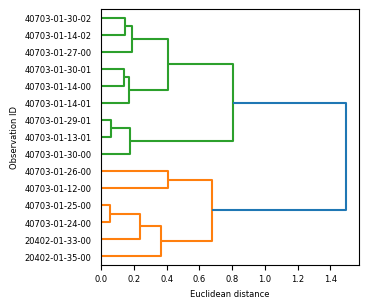

In [130]:
import scipy.cluster.hierarchy as sch
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})

linkage = sch.linkage(heatmap_data.iloc[:,:-1].astype(float), method="ward", metric="euclidean")
dendrogram = sch.dendrogram(linkage, truncate_mode=None, leaf_font_size = 6, labels=heatmap_data.index.values, orientation='right')
axis = plt.gca()

axis.set_xlabel("Euclidean distance")
axis.set_ylabel("Observation ID")

# plt.savefig('figures_paper/kappa_omega_dendogram.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

plt.show()

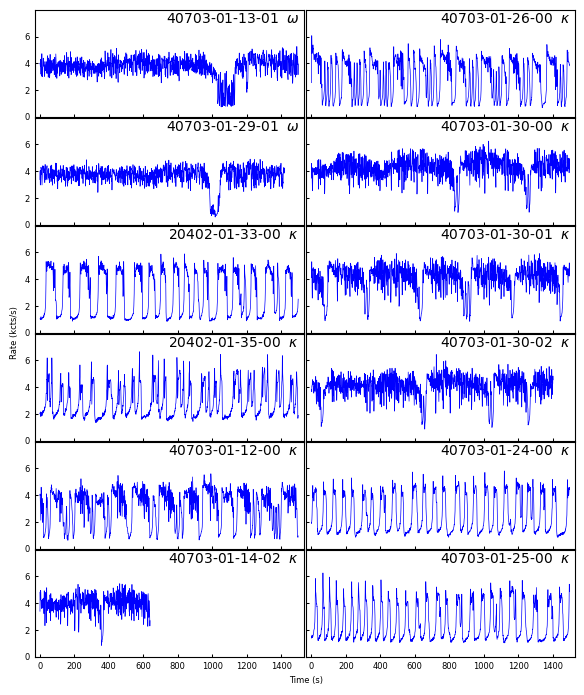

In [146]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
#https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib


# pylab.rcParams['figure.figsize'] = (3.15, 8.4) # A4 size 210mm x 297mm
plt.rcParams['figure.figsize'] = (6.97, 8.4)
plt.rcParams.update({'font.size': 6})


fig, axes = plt.subplots(nrows=6, ncols=2)
# axes = axes.flatten()

plt.subplots_adjust(hspace=0.01)
plt.subplots_adjust(wspace=0.01)
# plt.subplots_adjust(hspace=0)#0.05
# plt.subplots_adjust(wspace=0)#0.01

#'40703-01-14-00', '40703-01-14-01','40703-01-27-00',
# ids of 3 omega and 12 kappa observations
omega_kappa_ids = np.array(['40703-01-13-01',  '40703-01-29-01',
       '20402-01-33-00', '20402-01-35-00', '40703-01-12-00',
        '40703-01-14-02',
       '40703-01-24-00', '40703-01-25-00', '40703-01-26-00',
       '40703-01-30-00', '40703-01-30-01', '40703-01-30-02'], dtype=str)

for plot_ind, omega_kappa_id in enumerate(omega_kappa_ids):
    light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
    if plot_ind>5:
        col_ind = 1
        row_ind = plot_ind-8
#         axes[row_ind, col_ind].yaxis.tick_right()
    else:
        col_ind = 0
        row_ind = plot_ind
    axes[row_ind, col_ind].plot(light_c[0][:1500]-light_c[0][0], light_c[1][:1500]/1000, c="blue", linewidth=0.5, zorder=1)

#     
    axes[row_ind, col_ind].set_ylim([0, 8])
    axes[row_ind, col_ind].set_xlim([-30, 1530])
#     axes[plot_ind, 1].set_xlim([0, 512])

    axes[row_ind, col_ind].text(0.985,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=axes[row_ind, col_ind].transAxes, size=10)
        
    axes[row_ind, col_ind].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
    axes[row_ind, col_ind].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

    axes[row_ind, col_ind].set_yticks([0, 2,4,6])
    axes[row_ind, col_ind].set_yticklabels([0, 2, 4, 6])
    
    if col_ind == 1:
        axes[row_ind, col_ind].set_yticklabels(["", "", "", ""])

    
axes[2, 0].set_ylabel("Rate (kcts/s)", size=6, y=0)
axes[5, 1].set_xlabel("Time (s)", size=6,x=0)

# plt.savefig('figures_paper/kappa_omega_lightcurves_12.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)
plt.show()

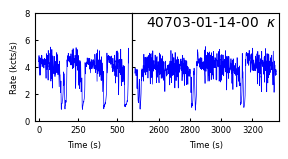

In [143]:
plt.rcParams['figure.figsize'] = (3.15, 8.4/6)
plt.rcParams.update({'font.size': 6})


# fig, axes = plt.subplots(nrows=1, ncols=20)
# axes = axes.flatten()
fig = plt.figure()

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)

lc_ind = 1
break_point = break_point_list[lc_ind]+1
omega_kappa_id = omega_kappa_ids[lc_ind]

ax1 = plt.subplot2grid((1, 20), (0, 0), rowspan=1, colspan=8)#, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax2 = plt.subplot2grid((1, 20), (0, 8), rowspan=1, colspan=12, yticks=[])#, xticklabels=[], yticklabels=[], xticks=[])


light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
ax1.plot(light_c[0][:break_point]-light_c[0][0], light_c[1][:break_point]/1000, c="blue", linewidth=0.5, zorder=1)
ax2.plot(light_c[0][break_point:]-light_c[0][0], light_c[1][break_point:]/1000, c="blue", linewidth=0.5, zorder=1)


ax1.set_ylim([0, 8])
ax2.set_ylim([0, 8])
ax1.set_xlim([-25, 574+25])
ax2.set_xlim([2448-15, 2448+906+15])

ax2.text(0.985,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=ax2.transAxes, size=10)
ax1.set_ylabel("Rate (kcts/s)", size=6)
ax1.set_xlabel("Time (s)", size=6)
ax2.set_xlabel("Time (s)", size=6)

ax1.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax1.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

ax1.set_yticks([0, 2,4,6,8])
ax2.set_yticks([0, 2,4,6,8])
ax1.set_yticklabels([0, 2, 4, 6,8])
ax2.set_yticklabels(["", "", "", "",""])

# plt.savefig('figures_paper/40703-01-14-00_lightcurve.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)
plt.show()

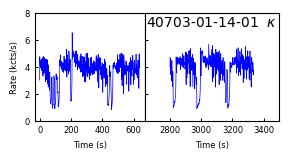

In [144]:
plt.rcParams['figure.figsize'] = (3.15, 8.4/6)
plt.rcParams.update({'font.size': 6})


# fig, axes = plt.subplots(nrows=1, ncols=20)
# axes = axes.flatten()
fig = plt.figure()

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)

lc_ind = 2
break_point = break_point_list[lc_ind]+1
omega_kappa_id = omega_kappa_ids[lc_ind]

ax1 = plt.subplot2grid((1, 20), (0, 0), rowspan=1, colspan=9)#, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax2 = plt.subplot2grid((1, 20), (0, 9), rowspan=1, colspan=11, yticks=[])#, xticklabels=[], yticklabels=[], xticks=[])


light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
ax1.plot(light_c[0][:break_point]-light_c[0][0], light_c[1][:break_point]/1000, c="blue", linewidth=0.5, zorder=1)
ax2.plot(light_c[0][break_point:]-light_c[0][0], light_c[1][break_point:]/1000, c="blue", linewidth=0.5, zorder=1)


ax1.set_ylim([0, 8])
ax2.set_ylim([0, 8])
ax1.set_xlim([-31, 639+32])
ax2.set_xlim([2801-162, 2801+534+162])

ax2.text(0.985,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=ax2.transAxes, size=10)
ax1.set_ylabel("Rate (kcts/s)", size=6)
ax1.set_xlabel("Time (s)", size=6)
ax2.set_xlabel("Time (s)", size=6)

ax1.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax1.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

ax1.set_yticks([0, 2,4,6,8])
ax2.set_yticks([0, 2,4,6,8])
ax1.set_yticklabels([0, 2, 4, 6,8])
ax2.set_yticklabels(["", "", "", "",""])

# plt.savefig('figures_paper/40703-01-14-01_lightcurve.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

plt.show()

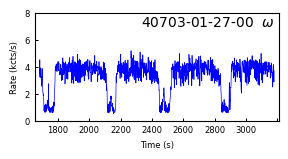

In [145]:

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)
lc_ind = 0
break_point = break_point_list[lc_ind]+1
omega_kappa_id = omega_kappa_ids[lc_ind]
light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]


fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(light_c[0][break_point:break_point+1500]-light_c[0][0], light_c[1][break_point:break_point+1500]/1000, c="blue", linewidth=0.5, zorder=1)
axes.set_ylim([0, 8])
axes.set_xlim([-30+1681.125, 1530+1681.125])
axes.set_ylabel("Rate (kcts/s)", size=6)
axes.set_xlabel("Time (s)", size=6)
axes.text(0.985,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=axes.transAxes, size=10)
plt.rcParams['figure.figsize'] = (3.32, 8.4/6)

axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")

axes.set_yticks([0, 2,4,6,8])
axes.set_yticklabels([0, 2, 4, 6,8])
axes.set_xticks([1800,2000,2200,2400,2600,2800,3000,3200])
axes.set_xticklabels([1800,2000,2200,2400,2600,2800,3000,""])

# plt.savefig('figures_paper/40703-01-27-00_lightcurve.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

plt.show()

In [148]:
loss_files = ["loss_history-2020-12-20_11-11-27.txt",
 "loss_history-2020-12-21_10-56-42.txt",
 "loss_history-2020-12-21_15-11-54.txt",
 "loss_history-2020-12-21_20-11-39.txt",
 "loss_history-2020-12-22_11-44-55.txt",
 "loss_history-2020-12-23_13-48-52.txt",
 "loss_history-2020-12-23_21-19-28.txt",
 "loss_history-2020-12-24_13-14-02.txt"]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


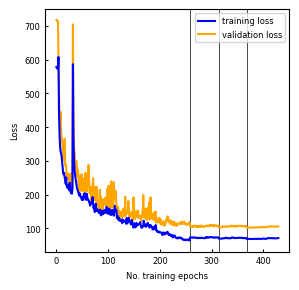

In [157]:
plt.rcParams['figure.figsize'] = (3.15,3.15)

plt.rcParams.update({'font.size': 6})

fig, axes = plt.subplots(nrows=1, ncols=1)



current_epoch = 0

hist_file = np.loadtxt("relevant_training_history/{}".format(loss_files[0]), delimiter=",")
x = np.arange(current_epoch, current_epoch+len(hist_file[0]), 1)
plt.plot(x, hist_file[0], c="blue", zorder=5, label="training loss")#, linestyle="--")
plt.plot(x, hist_file[1], c="orange", zorder=4, label="validation loss")
current_epoch += len(hist_file[0])
plt.axvline(current_epoch, zorder=-5, c="black", lw=0.5)




for file_name in loss_files[1:4]:
    hist_file = np.loadtxt("relevant_training_history/{}".format(file_name), delimiter=",")
    x = np.arange(current_epoch, current_epoch+len(hist_file[0]), 1)
    plt.plot(x, hist_file[0], c="blue", zorder=5)#, linestyle="--")
    plt.plot(x, hist_file[1], c="orange", zorder=4)
    current_epoch += len(hist_file[0])
    if current_epoch<400:
        plt.axvline(current_epoch, zorder=-5, c="black", lw=0.5)
plt.xlabel("No. training epochs", size=6)
plt.ylabel("Loss", size=6)
plt.legend(loc="upper right")

axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")

# plt.savefig('loss_curve_4s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)
# plt.savefig('figures_paper/loss_curve_4s.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


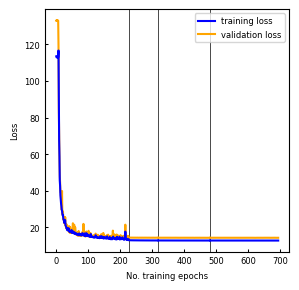

In [158]:
plt.rcParams['figure.figsize'] = (3.15,3.15)

plt.rcParams.update({'font.size': 6})

fig, axes = plt.subplots(nrows=1, ncols=1)

current_epoch = 0

hist_file = np.loadtxt("relevant_training_history/{}".format(loss_files[4]), delimiter=",")
x = np.arange(current_epoch, current_epoch+len(hist_file[0]), 1)
plt.plot(x, hist_file[0], c="blue", zorder=5, label="training loss")#, linestyle="--")
plt.plot(x, hist_file[1], c="orange", zorder=4, label="validation loss")
current_epoch += len(hist_file[0])
plt.axvline(current_epoch, zorder=-5, c="black", lw=0.5)




for file_name in loss_files[5:]:
    hist_file = np.loadtxt("relevant_training_history/{}".format(file_name), delimiter=",")
    x = np.arange(current_epoch, current_epoch+len(hist_file[0]), 1)
    plt.plot(x, hist_file[0], c="blue", zorder=5)#, linestyle="--")
    plt.plot(x, hist_file[1], c="orange", zorder=4)
    current_epoch += len(hist_file[0])
    if current_epoch<600:
        plt.axvline(current_epoch, zorder=-5, c="black", lw=0.5)
plt.xlabel("No. training epochs", size=6)
plt.ylabel("Loss", size=6)
plt.legend(loc="upper right")

axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")


# plt.savefig('loss_curve_1s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)
# plt.savefig('figures_paper/loss_curve_1s.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [160]:
# bics474_2d = []
# # for comps in [50,80,100,150,190,200,210,220,221,222,223,224,225,226,227,229,230,231,232,235,240,250,260,270,290,300,350,400]:
# for comps in [50,80,100,150,190,200,210,220,221,222,223,224,225,226,227,229,230,231,232,235,240,250,260,270,290,300,350,400]:
#     with open("{}/GMM_{}comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir, comps), 'rb') as f:
#         GMmodel = pickle.load(f)
        
#     bic474 = GMmodel.bic(shape_moments)
#     bics474_2d.append((comps, bic474))

# with open("{}/GMM_BIC_values_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'wb') as f:
#     pickle.dump(bics474_2d, f)

with open('{}/GMM_BIC_values_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    bics474_2d = pickle.load(f)
    
sorted_bics474 = pd.DataFrame(bics474_2d).sort_values(by=0)

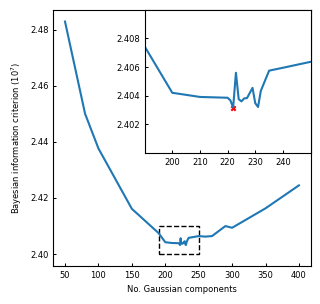

In [168]:
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = (3.32,3.32)

plt.rcParams.update({'font.size': 6})


fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.40, 0.45, 0.5, 0.43]# 0.45, 0.35, 0.45, 0.53
ax2 = fig.add_axes([left, bottom, width, height])

minimums = []
# fig, axes = plt.subplots(nrows=1, ncols=1)

ax1.plot(sorted_bics474.iloc[:,0], sorted_bics474.iloc[:,1]/1e7)
ax2.plot(sorted_bics474.iloc[:,0], sorted_bics474.iloc[:,1]/1e7)


# for iteration, dataset_bics in enumerate(bics):
#     minimums.append(component_no_list[np.argmin(dataset_bics)])
#     ax1.plot(component_no_list,dataset_bics/1e7)
#     ax2.plot(component_no_list,dataset_bics/1e7)

rect = patches.Rectangle((190, 2.40),60,0.01,linewidth=1,edgecolor='black',facecolor='none', linestyle ="--")

# Add the patch to the Axes
ax1.add_patch(rect)

# ax2.plot(component_no_list,np.mean(bics, axis=0)/1e7, marker = ".", c="cyan", label="mean")
ax2.set_xlim([190,250])
ax2.set_ylim([2.40,2.41])
# plt.legend(fontsize=6)
# plt.title("BIC values for Gaussian mixture models fit to 5 data subsets of 50k segments")
ax1.set_xlabel("No. Gaussian components", size=6)
ax1.set_ylabel("Bayesian information criterion ($10^7$)", size=6)

ax1.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax1.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

ax2.set_yticks(np.arange(2.402,2.409, 0.002))
ax2.set_xticks(np.arange(200, 250, 10))

ax2.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

# axes[plot_ind, 0].set_yticklabels([0, "", 5, "", 10, "",])

# ax1.plot(range(10), color='red')
# ax2.plot(range(6)[::-1], color='green')

bottom_y,top_y=ax1.get_ylim()
left_x, right_x = ax1.get_xlim()


ax2.scatter(222, 2.403163, c="red", marker="x", s=10)


# ax1.plot([90, left_x+(0.40*(right_x-left_x))], [1.62, bottom_y+(0.35*(top_y-bottom_y))], c="black", linestyle ="--",linewidth=1)
# ax1.plot([150, right_x], [1.62, bottom_y+(0.35*(top_y-bottom_y))], c="black", linestyle ="--",linewidth=1)
# ax1.set_xlim((left_x, right_x))
# ax1.axvline(157)#left_x+(0.45*(right_x)))

# plt.savefig('figures_paper/bic_curve_1s.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)



plt.show()


In [169]:
# load light curve segments
with open('{}/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-21_20-11-39.h5"
segments_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [468202, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [173]:
# bics468_2d = []
# for comps in [50,  80, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200,250, 255, 260, 265, 270, 275, 276, 277, 278, 279, 280, 281, 282,283, 284, 285, 290, 295, 300, 310, 320, 330, 340, 350, 400, 450,500]:
#     with open("{}/GMM_{}comps_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl".format(data_dir, comps), 'rb') as f:
#         GMmodel = pickle.load(f)
        
#     bic = GMmodel.bic(shape_moments)
#     bics468_2d.append((comps, bic))
    
# with open("{}/GMM_BIC_values_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl".format(data_dir), 'wb') as f:
#     pickle.dump(bics468_2d, f)

with open('{}/GMM_BIC_values_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    bics468_2d = pickle.load(f)
    
sorted_bics468 = pd.DataFrame(bics468_2d).sort_values(by=0)

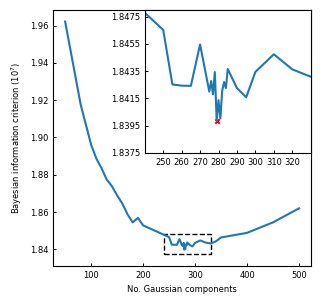

In [178]:
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = (3.32,3.32)

plt.rcParams.update({'font.size': 6})


fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.40, 0.45, 0.5, 0.43]# 0.45, 0.35, 0.45, 0.53
ax2 = fig.add_axes([left, bottom, width, height])

minimums = []
# fig, axes = plt.subplots(nrows=1, ncols=1)

ax1.plot(sorted_bics468.iloc[:,0], sorted_bics468.iloc[:,1]/1e7)
ax2.plot(sorted_bics468.iloc[:,0], sorted_bics468.iloc[:,1]/1e7)


# for iteration, dataset_bics in enumerate(bics):
#     minimums.append(component_no_list[np.argmin(dataset_bics)])
#     ax1.plot(component_no_list,dataset_bics/1e7)
#     ax2.plot(component_no_list,dataset_bics/1e7)

rect = patches.Rectangle((240, 1.8375),90,0.0105,linewidth=1,edgecolor='black',facecolor='none', linestyle ="--")

# Add the patch to the Axes
ax1.add_patch(rect)

# ax2.plot(component_no_list,np.mean(bics, axis=0)/1e7, marker = ".", c="cyan", label="mean")
ax2.set_xlim([240,330])
ax2.set_ylim([1.8375,1.848])
# plt.legend(fontsize=6)
# plt.title("BIC values for Gaussian mixture models fit to 5 data subsets of 50k segments")
ax1.set_xlabel("No. Gaussian components", size=6)
ax1.set_ylabel("Bayesian information criterion ($10^7$)", size=6)

ax1.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax1.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

ax2.set_yticks(np.arange(1.8375,1.8475, 0.002))
ax2.set_xticks(np.arange(250, 330, 10))

ax2.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

# axes[plot_ind, 0].set_yticklabels([0, "", 5, "", 10, "",])

# ax1.plot(range(10), color='red')
# ax2.plot(range(6)[::-1], color='green')

bottom_y,top_y=ax1.get_ylim()
left_x, right_x = ax1.get_xlim()


ax2.scatter(279, 1.839867234240892, c="red", marker="x", s=10)


# ax1.plot([90, left_x+(0.40*(right_x-left_x))], [1.62, bottom_y+(0.35*(top_y-bottom_y))], c="black", linestyle ="--",linewidth=1)
# ax1.plot([150, right_x], [1.62, bottom_y+(0.35*(top_y-bottom_y))], c="black", linestyle ="--",linewidth=1)
# ax1.set_xlim((left_x, right_x))
# ax1.axvline(157)#left_x+(0.45*(right_x)))

# plt.savefig('figures_paper/bic_curve_4s.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [179]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_222comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_1s = pickle.load(f)

umap_transformer = umap.UMAP(random_state=0).fit(GMmodel_1s.means_)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


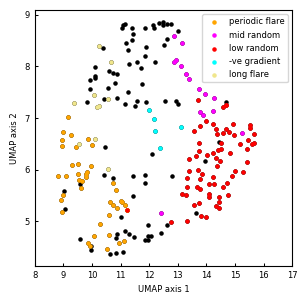

In [186]:
plt.rcParams['figure.figsize'] = (3.32,3.32)
plt.rcParams.update({'font.size': 6})


embedding = umap_transformer.embedding_

zorders = [-1]*122
labels = ["Other"]*122

s=5

fig, ax = plt.subplots()

plt.scatter(embedding[:,0], embedding[:,1], c="black", s=s)


filter_indices = [13,16,19,29,34,39,44,46,49,52,55,77,78,81,86,105,107,108,117,124,130,141,151,155,157,159,160,165,166,169,170,
172,177,185,186,187,189,190,206,213,218,219]# regular peaks

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="orange", label= "periodic flare", s=s)


colour_filter = ["orange" if x in filter_indices else "black" for x in range(122)]
zorders = [1 if ind in filter_indices else x for ind, x in enumerate(zorders)]
labels = ["Periodic flare" if ind in filter_indices else x for ind, x in enumerate(zorders)]

filter_indices = [20,23,28,40,47,53,58,69,83,102,116,137,178,196,201]# mid-flats

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="magenta", label= "mid random", s=s)


colour_filter = ["magenta" if ind in filter_indices else x for ind, x in enumerate(colour_filter)]
zorders = [1 if ind in filter_indices else x for ind, x in enumerate(zorders)]
labels = ["Mid random" if ind in filter_indices else x for ind, x in enumerate(zorders)]

filter_indices = [0, 1, 2,3,4,7,8,9,12,14,15,17,18,27,31,35,36,41,42,48,51,54,60,61,64,65,66,75,82,84,85,88,89,90,94,100,106,
110,112,113,120,122,123,126,127,132,145,146,147,148,152,154,157,161,162,164,171,173,176,176,193,194,202,203,
204,207,208,211,212]# low-flats

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="red", label= "low random", s=s)


filter_indices = [10,11,21,199, 68]# -ve grad

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="cyan", label= "-ve gradient", s=s)

filter_indices = [6,33,57,67,97,104,119,131,158,205]
plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="khaki", label= "long flare", s=s)

colour_filter = ["cyan" if ind in filter_indices else x for ind, x in enumerate(colour_filter)]
zorders = [1 if ind in filter_indices else x for ind, x in enumerate(zorders)]
labels = ["Low random" if ind in filter_indices else x for ind, x in enumerate(zorders)]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

ax.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

# filter_indices = [19,34,39,70]# irregular peaks

# colour_filter = ["red" if ind in filter_indices else x for ind, x in enumerate(colour_filter)]

# plt.scatter(embedding[:,0], embedding[:,1], c=colour_filter)
plt.legend()

plt.xlim((8,17))

# plt.savefig('figures_paper/UMAP_GMM_components.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [187]:
# load observation classifications from Huppenkothen 2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
# load IDs of segmented light curves: observationsID_segmentIndex
with open('{}/468202_len128_stride8_4sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

        
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [192]:
segments_dir = '{}/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'.format(data_dir)
errors_dir = '{}/468202_len128_stride8_4sec_cad_errors_sum_bin.pkl'.format(data_dir)
recos_dir = "{}/reconstructions_model_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl".format(data_dir)

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(recos_dir, 'rb') as f:
    recos = pickle.load(f)

recos= recos*np.std(segments, axis=1) + np.mean(segments, axis=1)

# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

In [193]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)
test_ids = [seg.split("_")[0] for seg in split_ob_ids[2]]

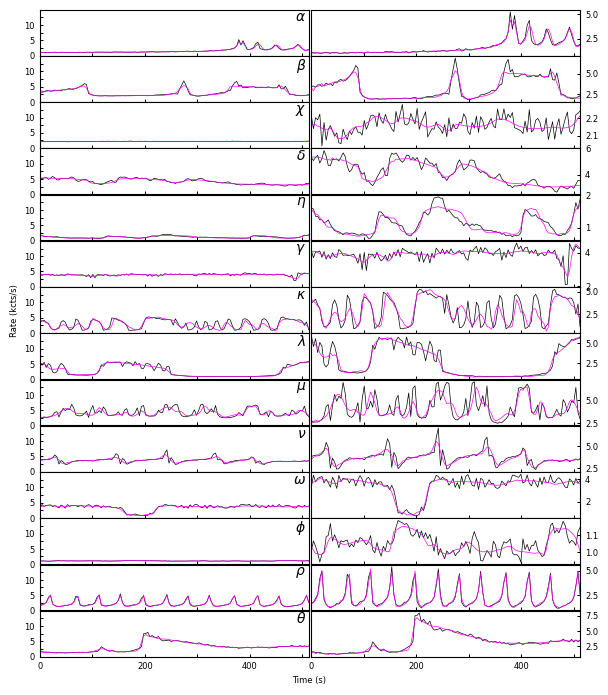

In [195]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
#https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib


# pylab.rcParams['figure.figsize'] = (3.15, 8.4) # A4 size 210mm x 297mm
plt.rcParams['figure.figsize'] = (6.97, 8.4)
plt.rcParams.update({'font.size': 6})


# colors = matplotlib.colors.CSS4_COLORS.keys()
# colors = np.array(list(colors))


# NUM_COLORS = 14
# cm = plt.get_cmap("jet")#('gist_rainbow')
# colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ids_ar = np.array(segment_class)

# class_names = list(inv_ob_state.keys())


alpha = np.where(ids_ar == "alpha")[0][0]#0
beta= np.where(ids_ar == "beta")[0][778]#7
gamma=np.where(ids_ar == "gamma")[0][0]
delta=np.where(ids_ar == "delta")[0][2]#5
theta=np.where(ids_ar == "theta")[0][0]#4
kappa=np.where(ids_ar == "kappa")[0][5]
lambda1=np.where(ids_ar == "lambda")[0][220]
mu=np.where(ids_ar == "mu")[0][1]
nu=np.where(ids_ar == "nu")[0][2]
rho=np.where(ids_ar == "rho")[0][1]
phi=np.where(ids_ar == "phi")[0][14]
chi=np.where(ids_ar == "chi")[0][13]
eta=np.where(ids_ar == "eta")[0][1]
omega=np.where(ids_ar == "omega")[0][3]


# selected_lcs = [alpha,beta,gamma,delta,theta,kappa,lambda1,mu,nu,rho,phi,chi,eta,omega]
selected_lcs = [alpha,beta,chi,delta,eta,gamma,kappa,lambda1,mu,nu,omega,phi,rho,theta]


fig, axes = plt.subplots(nrows=14, ncols=2)
# axes = axes.flatten()

plt.subplots_adjust(hspace=0.01)
plt.subplots_adjust(wspace=0.01)

# good_classes = ["delta", "mu", "rho", "phi"]
intervals = {}

class_names = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
class_names = np.sort(class_names)

for plot_ind in range(14):
    light_c = selected_lcs[plot_ind]
    class_name = class_names[plot_ind]    
    axes[plot_ind, 0].plot(np.linspace(0,512, num=128), segments[light_c], c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind, 0].plot(np.linspace(0,512, num=128), recos[light_c], c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind, 1].plot(np.linspace(0,512, num=128), segments[light_c]/1000, c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind, 1].plot(np.linspace(0,512, num=128), recos[light_c]/1000, c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind, 1].yaxis.tick_right()
    axes[plot_ind, 0].set_ylim([0, 15000])
    axes[plot_ind, 0].set_xlim([0, 512])
    axes[plot_ind, 1].set_xlim([0, 512])

    axes[plot_ind, 0].text(0.99,0.99,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind, 0].transAxes, size=10)
        
    axes[plot_ind, 0].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
    axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind].tick_params(axis="y", which="minor", length=2, width=0.75, labelsize=8, direction="in")


#     if plot_ind%2 == 0:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=8, direction="in")
#     else:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind].get_yticklabels(), visible=False)

    if plot_ind == 6:
        axes[plot_ind, 0].set_ylabel("Rate (kcts/s)", size=6)
    if plot_ind == 13:#plot_ind == 12 or plot_ind == 13:
        axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
        axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
        axes[plot_ind, 0].set_xlabel("Time (s)", size=6, x=1)

    else:
        axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind, 0].get_xticklabels(), visible=False)
        axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind, 1].get_xticklabels(), visible=False)
    
#     axes[plot_ind].set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
#     axes[plot_ind].set_yticklabels([0, "", "", 6, "", "", 12, ""])
    axes[plot_ind, 0].set_yticks([0, 2500, 5000, 7500, 10000, 12500])
    axes[plot_ind, 0].set_yticklabels([0, "", 5, "", 10, "",])
    axes[plot_ind, 0].set_xticks([0, 100, 200,300, 400, 500])
    axes[plot_ind, 0].set_xticklabels([0, "", 200,"", 400, ""])
    axes[plot_ind, 1].set_xticks([0, 100, 200,300, 400, 500])
    axes[plot_ind, 1].set_xticklabels([0, "", 200,"", 400, ""])
    
# plt.savefig('figures_paper/segment_reconstruction_4s.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)

# plt.legend()
plt.show()

In [201]:
segments_dir = '{}/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir)
errors_dir = '{}/474471_len128_stride10_1sec_cad_errors_sum_bin.pkl'.format(data_dir)
recos_dir = "{}/reconstructions_model_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir)

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(recos_dir, 'rb') as f:
    recos = pickle.load(f)

recos= recos*np.std(segments, axis=1) + np.mean(segments, axis=1)

# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

In [204]:
# load observation classifications from Huppenkothen 2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
# load IDs of segmented light curves: observationsID_segmentIndex
with open('{}/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

        
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [205]:
test_ids = [seg.split("_")[0] for seg in split_ob_ids[2]]

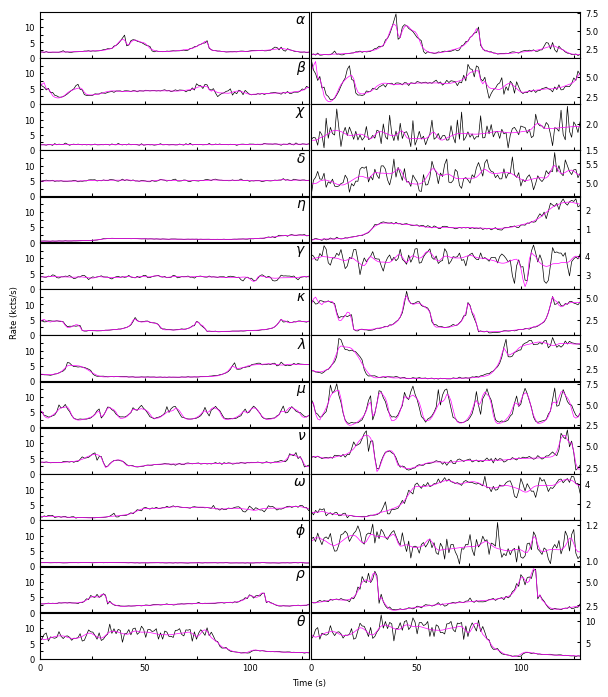

In [208]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
#https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib


# pylab.rcParams['figure.figsize'] = (3.15, 8.4) # A4 size 210mm x 297mm
plt.rcParams['figure.figsize'] = (6.97, 8.4)
plt.rcParams.update({'font.size': 6})


# colors = matplotlib.colors.CSS4_COLORS.keys()
# colors = np.array(list(colors))


# NUM_COLORS = 14
# cm = plt.get_cmap("jet")#('gist_rainbow')
# colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ids_ar = np.array(segment_class)

# class_names = list(inv_ob_state.keys())


alpha = np.where(ids_ar == "alpha")[0][24]#
beta= np.where(ids_ar == "beta")[0][72]#
gamma=np.where(ids_ar == "gamma")[0][9] #
delta=np.where(ids_ar == "delta")[0][5]#
theta=np.where(ids_ar == "theta")[0][30]#
kappa=np.where(ids_ar == "kappa")[0][13] #
lambda1=np.where(ids_ar == "lambda")[0][110] # 
mu=np.where(ids_ar == "mu")[0][0] # 
nu=np.where(ids_ar == "nu")[0][6] # 
rho=np.where(ids_ar == "rho")[0][0] # 
phi=np.where(ids_ar == "phi")[0][4] # 
chi=np.where(ids_ar == "chi")[0][4] # 
eta=np.where(ids_ar == "eta")[0][3] # 
omega=np.where(ids_ar == "omega")[0][164] # 


selected_lcs = [alpha,beta,chi,delta,eta,gamma,kappa,lambda1,mu,nu,omega,phi,rho,theta]



fig, axes = plt.subplots(nrows=14, ncols=2)
# axes = axes.flatten()

plt.subplots_adjust(hspace=0.01)
plt.subplots_adjust(wspace=0.01)

# good_classes = ["delta", "mu", "rho", "phi"]
intervals = {}

class_names = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
class_names = np.sort(class_names)

for plot_ind in range(14):
    light_c = selected_lcs[plot_ind]
    class_name = class_names[plot_ind]    
    axes[plot_ind, 0].plot(np.linspace(0,128, num=128), segments[light_c], c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind, 0].plot(np.linspace(0,128, num=128), recos[light_c], c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind, 1].plot(np.linspace(0,128, num=128), segments[light_c]/1000, c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind, 1].plot(np.linspace(0,128, num=128), recos[light_c]/1000, c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind, 1].yaxis.tick_right()
    axes[plot_ind, 0].set_ylim([0, 15000])
    axes[plot_ind, 0].set_xlim([0, 128])
    axes[plot_ind, 1].set_xlim([0, 128])

    axes[plot_ind, 0].text(0.99,0.99,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind, 0].transAxes, size=10)
        
    axes[plot_ind, 0].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
    axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind].tick_params(axis="y", which="minor", length=2, width=0.75, labelsize=8, direction="in")


#     if plot_ind%2 == 0:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=8, direction="in")
#     else:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind].get_yticklabels(), visible=False)

    if plot_ind == 6:
        axes[plot_ind, 0].set_ylabel("Rate (kcts/s)", size=6)
    if plot_ind == 13:#plot_ind == 12 or plot_ind == 13:
        axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
        axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
        axes[plot_ind, 0].set_xlabel("Time (s)", size=6, x=1)

    else:
        axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind, 0].get_xticklabels(), visible=False)
        axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind, 1].get_xticklabels(), visible=False)
    
#     axes[plot_ind].set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
#     axes[plot_ind].set_yticklabels([0, "", "", 6, "", "", 12, ""])
    axes[plot_ind, 0].set_yticks([0, 2500, 5000, 7500, 10000, 12500])
    axes[plot_ind, 0].set_yticklabels([0, "", 5, "", 10, "",])
    axes[plot_ind, 0].set_xticks([0, 25, 50,75, 100, 125])
    axes[plot_ind, 0].set_xticklabels([0, "", 50,"", 100, ""])
    axes[plot_ind, 1].set_xticks([0, 25, 50,75, 100, 125])
    axes[plot_ind, 1].set_xticklabels([0, "", 50,"", 100, ""])

# plt.savefig('figures_paper/segment_reconstruction_1s.eps', format="eps", bbox_inches = 'tight',pad_inches = 0)
# plt.legend()
plt.show()